# Analysis function

In [76]:
import numpy as np
from scipy.optimize import fsolve
import datetime
import json
from nupack import *
from matplotlib import pyplot as plt
import re
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq
from scipy.integrate import odeint
from matplotlib.patches import Patch
from scipy.stats import linregress

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time

def getEndpoint(level, x, data, conditions):
    averages = []

    for i, c in enumerate(data.columns):
        col = c
        if lookupCondition(col, conditions) == level:
            y = [float(i) for i in data[col].values]
            avg = np.average(y[-10:])
            averages.append(avg)

    df = pd.DataFrame(averages).T
    df.columns = ['Average '+str(i+1) for i in range(len(averages))]
    df.insert(0, "Level", level)  # Insert the level name as the first column
    df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
    df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

    return df
  
  
def getAverageCurve(startTime, offset, level, x, data, conditions, fit):
    """
    Calculate the average curve and standard deviation from data columns based on certain conditions.

    Args:
    - startTime (float): Start time to begin averaging from.
    - offset (float): Offset for the x values.
    - level: Condition level to filter the data columns.
    - x (list): x values for the curve.
    - data (DataFrame): Data containing the curve data in its columns.
    - conditions: Conditions corresponding to each data column.
    - fit (tuple): Tuple containing two fit values.

    Returns:
    - tuple: x values, average y values, and standard deviation of y values.
    """

    y_curves = []

    for i, c in enumerate(data.columns):
        if i >= 2 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_curves.append(ynew)

    y_avg, y_std = average_and_std(y_curves)
    x_vals = [i + offset - startTime for i in x if i >= startTime]

    return x_vals, y_avg, y_std 
  
def completion_at_time(data,
                      baseline_data,
                      triggered_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      baseline_conditions,
                      triggered_conditions,
                      experimental_level,
                      base_line_level,
                      triggered_level,
                      verbose = False):


  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def average_first_n_with_std(n, average_series, std_series):
    av = average_series[:n].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[:n].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_first_n_with_std(5, *series_av_and_std(baseline_data, baseline_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(triggered_data, triggered_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)

def getInitial(level, x, data, conditions):
  averages = []

  for i, c in enumerate(data.columns):
      col = c
      if lookupCondition(col, conditions) == level:
          y = [float(i) for i in data[col].values]
          avg = np.average(y[0:10])
          averages.append(avg)

  df = pd.DataFrame(averages).T
  df.columns = ['Average '+str(i+1) for i in range(len(averages))]
  df.insert(0, "Level", f"{level} init")  # Insert the level name as the first column
  df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
  df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

  return df

def timeToSec(time_string):
  split_string = time_string.split(":")
  return int(split_string[0])*3600 + int(split_string[1])*60 + int(split_string[2])

def lookupCondition(columnHeader, conds):
    keys = conds.keys()
    count = 0
    out = ""
    for e in conds.values():
        if columnHeader in e:
            count += 1
            out = list(conds.keys())[list(conds.values()).index(e)]
    assert(count <= 1)
    
    return out
  
def plotCalibratedAverages(level, x, ax, data, conditions, fit, color_dict, format_dict=None):
    data_list = []
    for i, c in enumerate(data.columns):
        col = c 
        if i>= 2 and lookupCondition(col, conditions) == level:
            ynew = [(float(x) - fit[0])/fit[1] for x in data[col].values]
            data_list.append(ynew)
            
    data_array = np.array(data_list)
    y_mean = np.mean(data_array, axis=0)
    y_std = np.std(data_array, axis=0)
    
    lab = 'Av' + level
    color = color_dict[level] if level in color_dict else 'blue' # set default color to blue

    if format_dict is None:
        format_dict = {'point_size': 1, 'point_opacity': 0.6, 'fill_opacity': 0.5}

    point_size = format_dict.get('point_size', 1)
    point_opacity = format_dict.get('point_opacity', 0.6)
    fill_opacity = format_dict.get('fill_opacity', 0.5)

    ax.scatter(x, y_mean, label=lab, color=color, alpha=point_opacity, s=[point_size]*len(y_mean))
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=fill_opacity)
    
  
def getTriplicatesJackknife(startTime, offset, level, x, data, conditions, fit):
    """
    Leave-one-out version of getAverageCurve.
    Returns 3 average curves and their standard deviations, each leaving out one replicate.

    Args:
    - startTime (float): Start time for truncating the curves.
    - offset (float): Time offset to apply to x values.
    - level: Condition label to match columns.
    - x (list or array): Full time array.
    - data (DataFrame): Curve data in columns.
    - conditions (dict): Mapping of column names to experimental conditions.
    - fit (tuple): Background subtraction and normalization (offset, scale).

    Returns:
    - x_vals (list): Timepoints corresponding to returned curves.
    - y_curves (list of 3 lists): Each is a leave-one-out average curve.
    - y_stds   (list of 3 lists): Each is the std deviation matching the y_curves.
    """
    y_all = []
    for i, c in enumerate(data.columns):
        if i >= 1 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_all.append(ynew)

    if len(y_all) != 3:
        print(conditions[level])
        for y in y_all:
          print(y[0:10])
        raise ValueError(f"Expected 3 replicates, found {len(y_all)} for level {level}")

    x_vals = [i + offset - startTime for i in x if i >= startTime]

    y_curves = []
    y_stds = []

    for i in range(3):
        subset = [y for j, y in enumerate(y_all) if j != i]
        avg, std = average_and_std(subset)
        y_curves.append(avg)
        y_stds.append(std)

    return x_vals, y_curves, y_stds


def average_and_std(curves):
    curves_array = np.array(curves)
    mean_curve = np.mean(curves_array, axis=0)
    std_curve = np.std(curves_array, axis=0)
    return mean_curve.tolist(), std_curve.tolist()

# Importing data

In [77]:
UW_backgr = pd.read_csv("UW_backgr.csv")
conditions_UW_backgr = {'R alone' : ['B2', 'C2', 'D2'],
'N50_80uM: 25000.0 nM, R1_1uM_cal: 40.0 nM' : ['B3', 'C3', 'D3'],
'R(nn) alone' : ['E2', 'F2', 'G2'],
'N50_80uM: 25000.0 nM, R1(nn)_1uM_cal: 40.0 nM' : ['E3', 'F3', 'G3']}
offset_UW_backgr = 0
t_UW_backgr = [offset_UW_backgr  + timeToSec(i) for i in list(UW_backgr['Time'].values)]
UW_trig = pd.read_csv("UW_trig.csv")
conditions_UW_trig = {'R background' : ['E9', 'F9', 'G9'],
              'no background nat' : ['E13', 'F13', 'G13'],
              'Trig N50_25uM nat' : ['E11', 'F11', 'G11'],
              'R(nn) background' : ['H9', 'I9', 'J9'],
              'no background nn' : ['H13', 'I13', 'J13'],
              'Trig N50_25uM nn' : ['H11', 'I11', 'J11']}
offset_UW_trig = 140
t_UW_trig = [offset_UW_trig  + timeToSec(i) for i in list(UW_trig['Time'].values)]


UW_rep = pd.read_csv("UW_rep.csv")
conditions_UW_rep = {'R background' : ['E8', 'F8', 'G8'],
              'no background nat' : ['E12', 'F12', 'G12'],
              'Rep N50_25uM nat' : ['E10', 'F10', 'G10'],
              'R(nn) background' : ['H8', 'I8', 'J8'],
              'no background nn' : ['H12', 'I12', 'J12'],
              'Rep N50_25uM nn' : ['H10', 'I10', 'J10']}
offset_UW_rep = 140
t_UW_rep = [offset_UW_rep + timeToSec(i) for i in list(UW_rep['Time'].values)]


UW_no = pd.read_csv("UW_no.csv")
conditions_UW_no = {'no background nat' : ['E3', 'F3', 'G3'],
'R background' : ['E4', 'F4', 'G4'],
'No N50_25uM nat' : ['E5', 'F5', 'G5'],
'no background nn' : ['H3', 'I3', 'J3'],
'R(nn) background' : ['H4', 'I4', 'J4'],
'No N50_25uM nn' : ['H5', 'I5', 'J5']}
offset_UW_no = 140
t_UW_no = [offset_UW_no + timeToSec(i) for i in list(UW_no['Time'].values)]


TUM_controls = pd.read_csv("TUM_controls.csv")
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3'],
                          'no background nat' : ['OneStep_1',	'OneStep_2',	'OneStep_3'],
                          'no background nn' : ['OneStep(nn)_1',	'OneStep(nn)_2',	'OneStep(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) + offset_TUM_controls for t in TUM_controls['time'].values]

TUM_no = pd.read_csv("TUM_no.csv")
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) + offset_TUM_no for t in TUM_no['time'].values]

TUM_trig = pd.read_csv("TUM_trig.csv")
conditions_TUM_trig = {'Trig inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Trig inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Trig inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Trig inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Trig inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Trig inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Trig inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Trig inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_trig = 0
t_TUM_trig = [int(t) + offset_TUM_trig for t in TUM_trig['time'].values]


TUM_rep = pd.read_csv("TUM_rep.csv")
conditions_TUM_rep = {'Rep inc nat N25-10uM' : ['Rep inc N25-10µM_1',	'Rep inc N25-10µM_2',	'Rep inc N25-10µM_3'],
                       'Rep inc nat N25-25uM' : ['Rep inc N25-25µM_1',	'Rep inc N25-25µM_2',	'Rep inc N25-25µM_3'],
                       'Rep inc nat N50-10uM' : ['Rep inc N50-10µM_1',	'Rep inc N50-10µM_2',	'Rep inc N50-10µM_3'],
                       'Rep inc nat N50-25uM' : ['Rep inc N50-25µM_1',	'Rep inc N50-25µM_2',	'Rep inc N50-25µM_3'],
                       'Rep inc nn N25-10uM' : ['Rep inc N25-10µM(nn)_1',	'Rep inc N25-10µM(nn)_2',	'Rep inc N25-10µM(nn)_3'],
                       'Rep inc nn N25-25uM' : ['Rep inc N25-25µM(nn)_1',	'Rep inc N25-25µM(nn)_2',	'Rep inc N25-25µM(nn)_3'],
                       'Rep inc nn N50-10uM' : ['Rep inc N50-10µM(nn)_1',	'Rep inc N50-10µM(nn)_2',	'Rep inc N50-10µM(nn)_3'],
                       'Rep inc nn N50-25uM' : ['Rep inc N50-25µM(nn)_1',	'Rep inc N50-25µM(nn)_2',	'Rep inc N50-25µM(nn)_3'],
                       }
offset_TUM_rep = 0
t_TUM_rep = [int(t) + offset_TUM_rep for t in TUM_rep['time'].values]

# 6 hr rate constants (1 parameter)

In [78]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

In [79]:
number_of_points = 6*3600//60

## Fitting

### Controls

#### Natural

Fitted kf = 7.6e+03 ± 7.6e+02 (jackknife SE, n=3)
RMSE = 5.039e-10
nRMSE (normed by mean)  = 0.032


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/493643919.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf * R1 * Y1)


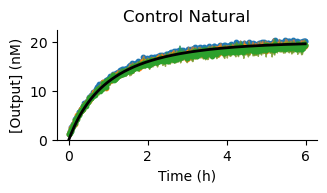

In [80]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

# --- cache jackknife once per level ---
for l in levels:
    x_jk, curves_jk, stds_jk = getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)
    curves.append([x_jk, [1e-9*np.array(c) for c in curves_jk]])
    stdDev.append(stds_jk)

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]

def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        R1 = float(scale - P)
        dY1dt = -float(kf * R1 * Y1)
        dPdt = -dY1dt
        dWdt = dPdt
        return (dY1dt, dPdt, dWdt)

    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale),
                                rtol=1e-12, atol=1e-12)]
    if kf < 0:
        return [np.inf] * len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    total_residuals = []
    n = 0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1] + (t[n][-1] - t[n][-2]), t[n][-1] - t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i] >= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:]
        total_residuals.append(y - model_y)
        n += 1
    return np.concatenate(total_residuals)

def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    # leastsq with default full_output=0 -> returns just the parameter array
    result = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))
    return result  # result[0] is parameter array

# Initial parameters
y_init = [
    20.0,  # Y1
    0.0,   # P
    0.0,   # W
]
scale = 40

fixed_params_list = [
    {'y0': y_init, 'scale': scale}
]

initial_k = 2e1
x_list = [x_trunc]

# --- JACKKNIFE FITS ---
res = []
for curve in to_fit[0]:
    # result[0] is array([kf]), so index [0] to get scalar
    k_hat = fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0][0]
    res.append(k_hat)

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")


k_control_nat = [[kf_mean, kf_se]]

# --- plotting ---
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

for i, rep in enumerate(to_fit[0]):
    y_nM = [1e9 * v for v in rep]
    ax.scatter(x_th, y_nM, color=color_scheme[i], s=10)
    ax.fill_between(x_th,
                    np.array(y_nM) - np.array(stdDev[0][i]),
                    np.array(y_nM),
                    color=color_scheme[i], alpha=alph)
    ax.fill_between(x_th,
                    np.array(y_nM),
                    np.array(y_nM) + np.array(stdDev[0][i]),
                    color=color_scheme[i], alpha=alph)

ax.plot(x_h, [1e9 * v for v in modelOneStep(kf_mean, x, fixed_params_list[0])],
        'black', linewidth=line)
#print nRMSE
r = residuals(kf_mean, [x_trunc], to_fit[0], fixed_params_list)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

ax.set_ylim(0, 22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')
plt.savefig("TUM_control_nat.svg", dpi=400)
plt.show()


#### NN

Fitted kf = 2.2e+04 ± 1.1e+03 (jackknife SE, n=3)
RMSE = 3.560e-10
nRMSE (normed by mean)  = 0.019


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/1897472370.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf * R1 * Y1)


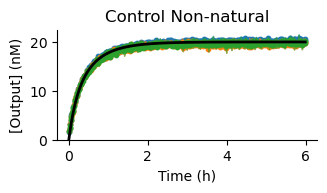

In [81]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

# --- cache jackknife once per level ---
for l in levels:
    x_jk, curves_jk, stds_jk = getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)
    curves.append([x_jk, [1e-9*np.array(c) for c in curves_jk]])
    stdDev.append(stds_jk)

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        R1 = float(scale - P)
        dY1dt = -float(kf * R1 * Y1)
        dPdt = -dY1dt
        dWdt = dPdt
        return (dY1dt, dPdt, dWdt)

    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale),
                                rtol=1e-12, atol=1e-12)]
    if kf < 0:
        return [np.inf] * len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    total_residuals = []
    n = 0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1] + (t[n][-1] - t[n][-2]), t[n][-1] - t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i] >= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:]
        total_residuals.append(y - model_y)
        n += 1
    return np.concatenate(total_residuals)

def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    # leastsq with default full_output=0 -> returns just the parameter array
    result = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))
    return result  # result[0] is parameter array

# Initial parameters
y_init = [
    20.0,  # Y1
    0.0,   # P
    0.0,   # W
]
scale = 40

fixed_params_list = [
    {'y0': y_init, 'scale': scale}
]

initial_k = 2e1
x_list = [x_trunc]

# --- JACKKNIFE FITS ---
res = []
for curve in to_fit[0]:
    # result[0] is array([kf]), so index [0] to get scalar
    k_hat = fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0][0]
    res.append(k_hat)

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

k_control_nn = [[kf_mean, kf_se]]

# --- plotting ---
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

for i, rep in enumerate(to_fit[0]):
    y_nM = [1e9 * v for v in rep]
    ax.scatter(x_th, y_nM, color=color_scheme[i], s=10)
    ax.fill_between(x_th,
                    np.array(y_nM) - np.array(stdDev[0][i]),
                    np.array(y_nM),
                    color=color_scheme[i], alpha=alph)
    ax.fill_between(x_th,
                    np.array(y_nM),
                    np.array(y_nM) + np.array(stdDev[0][i]),
                    color=color_scheme[i], alpha=alph)

ax.plot(x_h, [1e9 * v for v in modelOneStep(kf_mean, x, fixed_params_list[0])],
        'black', linewidth=line)
#print nRMSE
r = residuals(kf_mean, [x_trunc], to_fit[0], fixed_params_list)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

ax.set_ylim(0, 22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')
plt.savefig("TUM_control_nn.svg", dpi=400)
plt.show()


### No incubation
         

#### Nat

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/2360237422.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 2.8e+03 ± 2.0e+02 (jackknife SE)
RMSE = 4.267e-10
nRMSE (normed by mean)  = 0.038
Fitted kf = 1.1e+03 ± 8.2e+01 (jackknife SE)
RMSE = 5.666e-10
nRMSE (normed by mean)  = 0.083
Fitted kf = 2.9e+02 ± 4.3e+01 (jackknife SE)
RMSE = 4.129e-10
nRMSE (normed by mean)  = 0.174
Fitted kf = 1.1e+02 ± 7.6e+00 (jackknife SE)
RMSE = 2.514e-10
nRMSE (normed by mean)  = 0.243


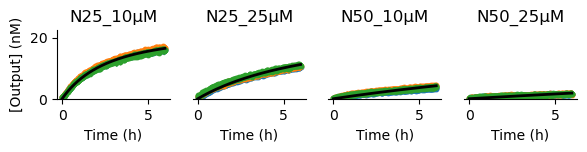

In [82]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]

def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nat = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")


    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



#### NN

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/55725418.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 9.1e+03 ± 5.4e+02 (jackknife SE)
RMSE = 4.638e-10
nRMSE (normed by mean)  = 0.028
Fitted kf = 4.8e+03 ± 2.7e+02 (jackknife SE)
RMSE = 4.929e-10
nRMSE (normed by mean)  = 0.035
Fitted kf = 2.1e+03 ± 2.8e+02 (jackknife SE)
RMSE = 9.913e-10
nRMSE (normed by mean)  = 0.101
Fitted kf = 5.9e+02 ± 3.3e+01 (jackknife SE)
RMSE = 4.503e-10
nRMSE (normed by mean)  = 0.107


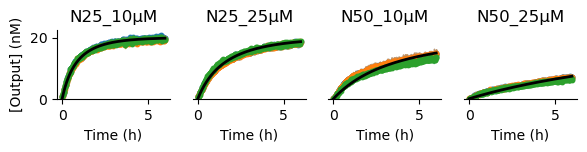

In [83]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nn = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_no_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_nn_noinc.svg', dpi = 500, transparent=True)
plt.show()



### Trig
         

#### Nat

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/1935682861.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 2.8e+03 ± 5.0e+01 (jackknife SE)
RMSE = 2.580e-10
nRMSE (normed by mean)  = 0.023
Fitted kf = 1.2e+03 ± 3.1e+01 (jackknife SE)
RMSE = 2.190e-10
nRMSE (normed by mean)  = 0.031
Fitted kf = 2.6e+02 ± 2.7e+00 (jackknife SE)
RMSE = 1.849e-10
nRMSE (normed by mean)  = 0.091
Fitted kf = 7.3e+01 ± 3.8e+00 (jackknife SE)
RMSE = 1.725e-10
nRMSE (normed by mean)  = 0.262


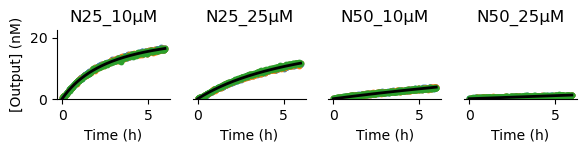

In [84]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 1, 2, 3]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x



# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nat = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_trig_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')
plt.savefig('TUM_nat_trig.svg', dpi = 500, transparent=True)

plt.show()

#### NN

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/3564407014.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 1.0e+04 ± 1.8e+02 (jackknife SE)
RMSE = 3.925e-10
nRMSE (normed by mean)  = 0.023
Fitted kf = 4.2e+03 ± 1.5e+02 (jackknife SE)
RMSE = 3.948e-10
nRMSE (normed by mean)  = 0.030
Fitted kf = 1.2e+03 ± 3.3e+01 (jackknife SE)
RMSE = 2.544e-10
nRMSE (normed by mean)  = 0.036
Fitted kf = 3.4e+02 ± 3.3e+00 (jackknife SE)
RMSE = 1.784e-10
nRMSE (normed by mean)  = 0.070


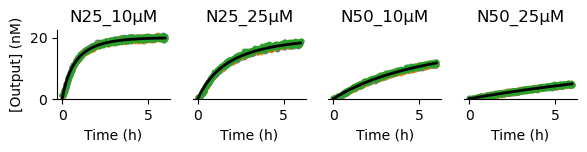

In [85]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}


curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [4,5,6,7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]

def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nn = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_trig_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_nn_trig.svg', dpi = 500, transparent=True)
plt.show()


### Rep
         

#### Nat

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/300794379.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 1.8e+03 ± 2.3e+01 (jackknife SE)
RMSE = 4.215e-10
nRMSE (normed by mean)  = 0.048
Fitted kf = 8.6e+02 ± 9.2e+00 (jackknife SE)
RMSE = 2.332e-10
nRMSE (normed by mean)  = 0.042
Fitted kf = 2.6e+02 ± 8.4e+00 (jackknife SE)
RMSE = 2.139e-10
nRMSE (normed by mean)  = 0.102
Fitted kf = 7.6e+01 ± 9.7e-01 (jackknife SE)
RMSE = 1.668e-10
nRMSE (normed by mean)  = 0.245


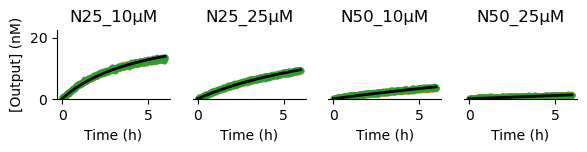

In [86]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']

data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_rep[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 1, 2, 3]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]

def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e2


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nat = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_rep_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_nat_rep.svg', dpi = 500, transparent=True)
plt.show()


#### NN

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/3951243798.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


Fitted kf = 6.7e+03 ± 2.6e+02 (jackknife SE)
RMSE = 5.992e-10
nRMSE (normed by mean)  = 0.039
Fitted kf = 4.0e+03 ± 3.8e+02 (jackknife SE)
RMSE = 4.898e-10
nRMSE (normed by mean)  = 0.038
Fitted kf = 1.7e+03 ± 4.7e+01 (jackknife SE)
RMSE = 3.201e-10
nRMSE (normed by mean)  = 0.037
Fitted kf = 4.6e+02 ± 1.6e+01 (jackknife SE)
RMSE = 2.386e-10
nRMSE (normed by mean)  = 0.071


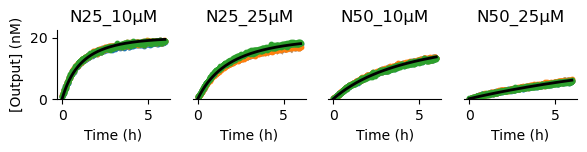

In [87]:
labels = ['N25_10\u03bcM', 'N25_25\u03bcM', 'N50_10\u03bcM', 'N50_25\u03bcM']


data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_rep[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [4, 5, 6, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]

def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x

# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nn = []
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_rep_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('TUM_nn_rep.svg', dpi = 500, transparent=True)
plt.show()


# UW N50_25uM data

In [88]:
fit_nat = [789.333333, (6701.566667-789.333333)/20]
fit_nn =  [278.600000, (7651.433333	-278.600000)/20]


### Controls

#### Natural

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/2294175182.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf * R1 * Y1)


Fitted kf = 6.1e+05 ± 6.0e+04 (jackknife SE, n=3)
RMSE = 5.423e-10
nRMSE (normed by mean)  = 0.027


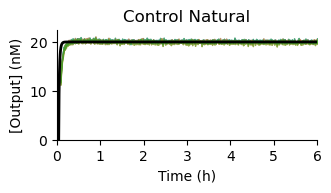

In [89]:
number_of_points = min([i for i, t in enumerate(t_UW_no) if t >= 3600*6]) + 1
data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = [list(conditions.keys())[0]]
offset = offset_UW_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

# --- cache jackknife once per level ---
for l in levels:
    x_jk, curves_jk, stds_jk = getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)
    curves.append([x_jk, [1e-9*np.array(c) for c in curves_jk]])
    stdDev.append(stds_jk)

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        R1 = float(scale - P)
        dY1dt = -float(kf * R1 * Y1)
        dPdt = -dY1dt
        dWdt = dPdt
        return (dY1dt, dPdt, dWdt)

    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale),
                                rtol=1e-12, atol=1e-12)]
    if kf < 0:
        return [np.inf] * len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    total_residuals = []
    n = 0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1
    return np.concatenate(total_residuals)

def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    # leastsq with default full_output=0 -> returns just the parameter array
    result = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))
    return result  # result[0] is parameter array

# Initial parameters
y_init = [
    20.0,  # Y1
    0.0,   # P
    0.0,   # W
]
scale = 40

fixed_params_list = [
    {'y0': y_init, 'scale': scale}
]

initial_k = 2
x_list = [x_trunc]

# --- JACKKNIFE FITS ---
res = []
for curve in to_fit[0]:
    # result[0] is array([kf]), so index [0] to get scalar
    k_hat = fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0][0]
    res.append(k_hat)

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

UW_k_control_nat = [[kf_mean, kf_se]]

# --- plotting ---
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

for i, rep in enumerate(to_fit[0]):
    y_nM = [1e9 * v for v in rep]
    ax.scatter(x_trunc, y_nM, color=color_scheme[i], s=10)
    ax.fill_between(x_th,
                    np.array(y_nM) - np.array(stdDev[0][i]),
                    np.array(y_nM),
                    color=color_scheme[i], alpha=alph)
    ax.fill_between(x_th,
                    np.array(y_nM),
                    np.array(y_nM) + np.array(stdDev[0][i]),
                    color=color_scheme[i], alpha=alph)

ax.plot(x_h, [1e9 * v for v in modelOneStep(kf_mean, x, fixed_params_list[0])],
        'black', linewidth=line)
# residuals for all replicates in condition 0
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

ax.set_ylim(0, 22.5)
ax.set_xlim(0,6)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')
plt.savefig("UW_control_nat.svg", dpi=400)
plt.show()


#### NN

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/3058272538.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf * R1 * Y1)


Fitted kf = 3.3e+06 ± 4.1e+04 (jackknife SE, n=3)
RMSE = 7.789e-10
nRMSE (normed by mean)  = 0.040


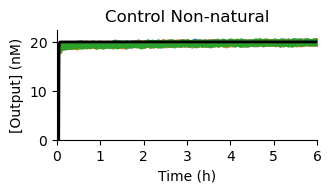

In [105]:
data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = [list(conditions.keys())[3]]
offset = offset_UW_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

# --- cache jackknife once per level ---
for l in levels:
    x_jk, curves_jk, stds_jk = getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)
    curves.append([x_jk, [1e-9*np.array(c) for c in curves_jk]])
    stdDev.append(stds_jk)

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        R1 = float(scale - P)
        dY1dt = -float(kf * R1 * Y1)
        dPdt = -dY1dt
        dWdt = dPdt
        return (dY1dt, dPdt, dWdt)

    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale),
                                rtol=1e-12, atol=1e-12)]
    if kf < 0:
        return [np.inf] * len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    total_residuals = []
    n = 0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params)
        total_residuals.append(y - model_y)
        n += 1
    return np.concatenate(total_residuals)

def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    # leastsq with default full_output=0 -> returns just the parameter array
    result = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))
    return result  # result[0] is parameter array

# Initial parameters
y_init = [
    20.0,  # Y1
    0.0,   # P
    0.0,   # W
]
scale = 40

fixed_params_list = [
    {'y0': y_init, 'scale': scale}
]

initial_k = 2
x_list = [x_trunc]

# --- JACKKNIFE FITS ---
res = []
for curve in to_fit[0]:
    # result[0] is array([kf]), so index [0] to get scalar
    k_hat = fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0][0]
    res.append(k_hat)

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

UW_k_control_nn = [[kf_mean, kf_se]]

# --- plotting ---
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

for i, rep in enumerate(to_fit[0]):
    y_nM = [1e9 * v for v in rep]
    ax.scatter(x_h, y_nM, color=color_scheme[i], s=10)
    ax.fill_between(x_th,
                    np.array(y_nM) - np.array(stdDev[0][i]),
                    np.array(y_nM),
                    color=color_scheme[i], alpha=alph)
    ax.fill_between(x_th,
                    np.array(y_nM),
                    np.array(y_nM) + np.array(stdDev[0][i]),
                    color=color_scheme[i], alpha=alph)

ax.plot(x_h, [1e9 * v for v in modelOneStep(kf_mean, x_trunc, fixed_params_list[0])],
        'black', linewidth=line)
# residuals for all replicates in condition 0
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

ax.set_ylim(0, 22.5)
ax.set_xlim(0,6)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')
plt.savefig("UW_control_nn.svg", dpi=400)
plt.show()


Fitted kf = 3.6e+02 ± 9.5e+00 (jackknife SE)
RMSE = 8.981e-10
nRMSE (normed by mean)  = 0.290


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/2624113819.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


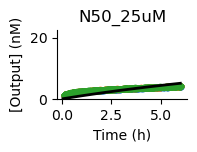

In [106]:
labels = ['N50_25uM']

data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [2]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nat = []
for i, a in enumerate([ax]):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition 0
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Fitted kf = 2.1e+03 ± 7.0e+01 (jackknife SE)
RMSE = 2.232e-09
nRMSE (normed by mean)  = 0.222


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/182740146.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


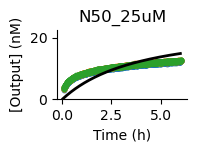

In [107]:
labels = ['N50_25uM']

data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [5]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nn = []
for i, a in enumerate([ax]):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_no_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Fitted kf = 2.4e+02 ± 7.8e+00 (jackknife SE)
RMSE = 3.300e-10
nRMSE (normed by mean)  = 0.168


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/3772435313.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


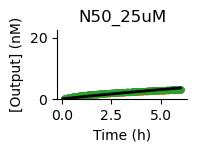

In [108]:
labels = ['N50_25uM']

data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [2]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nat = []
for i, a in enumerate([ax]):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_trig_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Fitted kf = 1.3e+03 ± 3.1e+01 (jackknife SE)
RMSE = 1.004e-09
nRMSE (normed by mean)  = 0.134


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/1277630299.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


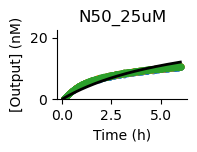

In [109]:
labels = ['N50_25uM']

data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [5]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nn = []
for i, a in enumerate([ax]):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_trig_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Fitted kf = 3.7e+02 ± 1.5e+01 (jackknife SE)
RMSE = 8.989e-10
nRMSE (normed by mean)  = 0.287


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/2496862115.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


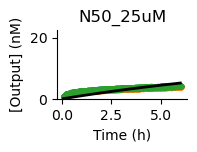

In [110]:
labels = ['N50_25uM']

data = UW_rep[0:number_of_points]
conditions = conditions_UW_rep
levels = list(conditions.keys())
offset = offset_UW_rep
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_UW_rep[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [2]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e1


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nat = []
for i, a in enumerate([ax]):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_rep_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Fitted kf = 2.4e+03 ± 9.3e+00 (jackknife SE)
RMSE = 2.517e-09
nRMSE (normed by mean)  = 0.231


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/2610880287.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))
/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_46705/2610880287.py:55: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]


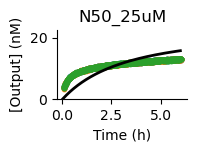

In [111]:
labels = ['N50_25uM']

data = UW_rep[0:number_of_points]
conditions = conditions_UW_rep
levels = list(conditions.keys())
offset = offset_UW_rep
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_UW_rep[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [5]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        model_y = modelOneStep(kf, t[n], fixed_params) # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x






# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]*4


initial_k = 2e5


x_list  = [x_trunc]*4




fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nn = []
for i, a in enumerate([ax]):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_rep_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
    # residuals for all replicates in condition i
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



## Summary Data

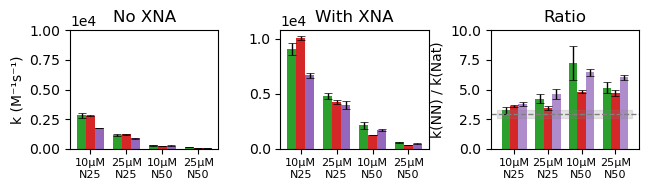


=== (1) Wald tests: Each bar vs control ratio ===
10μM N25     – No incubation    : ratio=3.247±0.305, Z= 0.693, p=4.882e-01, Holm=4.882e-01
10μM N25     – Trigger incubated: ratio=3.632±0.091, Z= 2.038, p=4.152e-02, Holm=1.245e-01
10μM N25     – Reporter incubated: ratio=3.794±0.155, Z= 2.357, p=1.840e-02, Holm=7.361e-02
25μM N25     – No incubation    : ratio=4.225±0.381, Z= 2.560, p=1.047e-02, Holm=5.234e-02
25μM N25     – Trigger incubated: ratio=3.459±0.152, Z= 1.443, p=1.490e-01, Holm=2.979e-01
25μM N25     – Reporter incubated: ratio=4.621±0.443, Z= 3.052, p=2.274e-03, Holm=1.592e-02
10μM N50     – No incubation    : ratio=7.223±1.433, Z= 2.916, p=3.545e-03, Holm=2.127e-02
10μM N50     – Trigger incubated: ratio=4.826±0.137, Z= 5.296, p=1.186e-07, Holm=1.186e-06
10μM N50     – Reporter incubated: ratio=6.442±0.271, Z= 8.213, p=2.220e-16, Holm=2.665e-15
25μM N50     – No incubation    : ratio=5.155±0.445, Z= 4.008, p=6.116e-05, Holm=4.893e-04
25μM N50     – Trigger incubated: ra

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.stats import norm

fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(2)


def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0]) * res_num[1])**2 +
                   ((res_num[0] / (res_denom[0]**2)) * res_denom[1])**2)

labels = [u"10\u03bcM\nN25", u"25\u03bcM\nN25", u"10\u03bcM\nN50", u"25\u03bcM\nN50"]
x = np.arange(len(labels))  # [0, 1, 2, 3]
bar_width = 0.25
\
# ---------------------------------------------------------
# Data assembly
# ---------------------------------------------------------

# Group datasets by color group
# Format for panel0: (nat, nn, color, alpha)
datasets_panel0 = [
    (k_no_nat,   k_no_nn,   color_scheme[2], 1.0),
    (k_trig_nat, k_trig_nn, color_scheme[3], 1.0),
    (k_rep_nat,  k_rep_nn,  color_scheme[4], 1.0),
]

# Ratios k(NN)/k(Nat) + propagated errors for each background & incubation
k_no_diff = [[k_no_nn[i][0]   / k_no_nat[i][0],   prop_err(k_no_nn[i],   k_no_nat[i])]
             for i in range(len(k_no_nn))]
k_trig_diff = [[k_trig_nn[i][0] / k_trig_nat[i][0], prop_err(k_trig_nn[i], k_trig_nat[i])]
               for i in range(len(k_trig_nn))]
k_rep_diff = [[k_rep_nn[i][0]  / k_rep_nat[i][0],  prop_err(k_rep_nn[i],  k_rep_nat[i])]
              for i in range(len(k_rep_nn))]

datasets_panel1 = [
    (k_no_diff,   'No incubation',       color_scheme[2], 1.0),
    (k_trig_diff, 'Trigger incubated',   color_scheme[3], 1.0),
    (k_rep_diff,  'Reporter incubated',  color_scheme[4], 0.75),
]

error_params = dict(ecolor='black', lw=1, capsize=3, capthick=0.5)

# ---------------------------------------------------------
# Plot nat and nn (panels 0 and 1)
# ---------------------------------------------------------
for i, (nat_list, nn_list, color, scale) in enumerate(datasets_panel0):
    nat_y = [v[0] for v in nat_list]
    nat_err = [v[1] for v in nat_list]
    nn_y = [v[0] for v in nn_list]
    nn_err = [v[1] for v in nn_list]

    # x positions for this dataset
    dx = (i - 1) * bar_width  # shifts: -bar_width, 0, +bar_width
    ax[0].bar(x + dx, nat_y, width=bar_width, yerr=nat_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)
    ax[1].bar(x + dx, nn_y, width=bar_width, yerr=nn_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)

# ---------------------------------------------------------
# Panel 2: draw ratio bars
# ---------------------------------------------------------
for i, (diff_list, label, color, scale) in enumerate(datasets_panel1):
    diff_y = [v[0] for v in diff_list]
    diff_err = [v[1] for v in diff_list]
    dx = (i - 1) * bar_width  # shift left, center, right
    ax[2].bar(x + dx, diff_y, width=bar_width, yerr=diff_err, error_kw=error_params,
              color=color, label=label, alpha=scale)

# Control ratio line + band
control_ratio = k_control_nn[0][0] / k_control_nat[0][0]
control_ratio_se = prop_err(k_control_nn[0], k_control_nat[0])

ax[2].axhline(y=control_ratio, color='gray', linestyle='--', linewidth=1)
ax[2].fill_between(
    [-0.5, 3.5],
    [control_ratio - control_ratio_se] * 2,
    [control_ratio + control_ratio_se] * 2,
    color='gray', alpha=0.2,
)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=8)
    a.tick_params(axis='x', labelrotation=0)

ax[0].set_ylim(0, 10000)
ax[2].set_ylim(0, 10)

ax[0].set_ylabel('k (M⁻¹s⁻¹)', fontsize=10)
ax[2].set_ylabel('k(NN) / k(Nat)', fontsize=10)

# Set y-axis 0 and 1 to scientific notation
ax[0].yaxis.get_major_formatter().set_scientific(True)
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 1))
ax[1].yaxis.get_major_formatter().set_scientific(True)
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 1))

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)

plt.tight_layout()
plt.savefig("NAR_Onestep_K.svg", dpi=400)
plt.show()

# ============================================================
# ===================== STATISTICS ===========================
# ============================================================

def wald_z(diff, se_diff):
    Z = diff / se_diff
    p = 2 * (1 - norm.cdf(abs(Z)))
    return Z, p

def holm_correction(pvals):
    """Holm step-down adjustment; returns adjusted p-values in original order."""
    m = len(pvals)
    order = sorted(range(m), key=lambda i: pvals[i])  # indices sorted by p
    adjusted = [0.0] * m
    prev = 0.0
    for rank, i in enumerate(order):
        k = m - rank
        adj = min(1.0, pvals[i] * k)
        adj = max(adj, prev)  # enforce monotonicity
        adjusted[i] = adj
        prev = adj
    return adjusted

# Convenience: collect ratios by incubation type
# Each list is length 4 (one per background)
ratios_no   = k_no_diff
ratios_trig = k_trig_diff
ratios_rep  = k_rep_diff

backgrounds = [u"10\u03bcM N25", u"25\u03bcM N25", u"10\u03bcM N50", u"25\u03bcM N50"]
incubations = ["No incubation", "Trigger incubated", "Reporter incubated"]

# ============================================================
# (1) Which bars differ from the control ratio?
#     (12 tests; Holm across all 12)
# ============================================================

print("\n=== (1) Wald tests: Each bar vs control ratio ===")

all_bar_results = []
pvals_bar = []

for i, bg in enumerate(backgrounds):
    for inc_label, (ratio_list, tag) in zip(
        incubations,
        [(ratios_no, 'No'),
         (ratios_trig, 'Trigger'),
         (ratios_rep, 'Reporter')]
    ):
        est, se = ratio_list[i]
        diff = est - control_ratio
        se_diff = sqrt(se**2 + control_ratio_se**2)
        Z, p = wald_z(diff, se_diff)
        pvals_bar.append(p)
        all_bar_results.append({
            "background": bg,
            "incubation": inc_label,
            "ratio": est,
            "se": se,
            "diff": diff,
            "se_diff": se_diff,
            "Z": Z,
            "p_raw": p,
        })

p_adj_bar = holm_correction(pvals_bar)
for res, p_h in zip(all_bar_results, p_adj_bar):
    res["p_holm"] = p_h

for r in all_bar_results:
    print(f"{r['background']:12s} – {r['incubation']:17s}: "
          f"ratio={r['ratio']:.3f}±{r['se']:.3f}, "
          f"Z={r['Z']:6.3f}, p={r['p_raw']:8.3e}, Holm={r['p_holm']:8.3e}")


# ============================================================
# (2) Within each background: No vs Trigger / No vs Reporter
#     Holm per background
# ============================================================

print("\n=== (2) Wald tests: Within-background incubation comparisons ===")

for i, bg in enumerate(backgrounds):
    print(f"\nBackground {bg}:")
    # For this background i, get (ratio, se) for each incubation
    r_no,   se_no   = ratios_no[i]
    r_trig, se_trig = ratios_trig[i]
    r_rep,  se_rep  = ratios_rep[i]

    comps = [
        ("Trigger vs No",   r_trig, se_trig, r_no, se_no),
        ("Reporter vs No",  r_rep,  se_rep,  r_no, se_no),
    ]

    pvals = []
    rows = []
    for name, r2, se2, r1, se1 in comps:
        diff = r2 - r1
        se_diff = sqrt(se1**2 + se2**2)
        Z, p = wald_z(diff, se_diff)
        pvals.append(p)
        rows.append((name, diff, se_diff, Z, p))

    p_adj = holm_correction(pvals)
    for (name, diff, se_diff, Z, p_raw), p_corr in zip(rows, p_adj):
        print(f"{name:14s}: diff={diff:6.3f}±{se_diff:5.3f}, "
              f"Z={Z:6.3f}, p={p_raw:8.3e}, Holm={p_corr:8.3e}")


# ============================================================
# (3) Global comparisons between incubation types
#     pooled across backgrounds (inverse-variance weighted)
#     Holm across the 3 global comparisons
# ============================================================

print("\n=== (3) Global (pooled) comparisons between incubation conditions ===")

inc_to_list = {
    "No incubation":      ratios_no,
    "Trigger incubated":  ratios_trig,
    "Reporter incubated": ratios_rep,
}

inc_pairs = [
    ("No incubation",      "Trigger incubated",  "No vs Trigger"),
    ("No incubation",      "Reporter incubated", "No vs Reporter"),
    ("Trigger incubated",  "Reporter incubated", "Trigger vs Reporter"),
]

global_results = []
pvals_global = []

for inc1, inc2, label in inc_pairs:
    list1 = inc_to_list[inc1]
    list2 = inc_to_list[inc2]

    num = 0.0
    den = 0.0

    for i in range(len(list1)):  # loop over 4 backgrounds
        r1, se1 = list1[i]
        r2, se2 = list2[i]
        diff_i = r2 - r1
        se_diff_i = sqrt(se1**2 + se2**2)
        var_i = se_diff_i**2
        w_i = 1.0 / var_i
        num += w_i * diff_i
        den += w_i

    if den == 0:
        continue

    pooled_diff = num / den
    pooled_se = sqrt(1.0 / den)
    Z, p = wald_z(pooled_diff, pooled_se)

    global_results.append({
        "label": label,
        "pooled_diff": pooled_diff,
        "pooled_se": pooled_se,
        "Z": Z,
        "p_raw": p,
    })
    pvals_global.append(p)

p_adj_global = holm_correction(pvals_global)
for res, p_h in zip(global_results, p_adj_global):
    res["p_holm"] = p_h

for res in global_results:
    print(f"{res['label']:16s}: pooled diff={res['pooled_diff']:.3f}±{res['pooled_se']:.3f}, "
          f"Z={res['Z']:6.3f}, p={res['p_raw']:8.3e}, Holm={res['p_holm']:8.3e}")


# ============================================================
# (4) Pooled tests: does each x-axis background (4 levels)
#     as a whole differ from the control ratio?
#     Here we pool the three incubation bars (No/Trigger/Reporter)
#     for each background as independent estimates.
#     Holm-correction across the 4 backgrounds.
# ============================================================

print("\n=== (4) Pooled tests: each background vs control (pooled across incubations) ===")

pooled_bg_results = []
pvals_bg = []

for i, bg in enumerate(backgrounds):
    # For background i, collect (est, se) for No / Trigger / Reporter
    vals = [
        ratios_no[i],    # (est_no, se_no)
        ratios_trig[i],  # (est_trig, se_trig)
        ratios_rep[i],   # (est_rep, se_rep)
    ]

    num = 0.0
    den = 0.0

    for est, se in vals:
        diff_i = est - control_ratio
        se_diff_i = sqrt(se**2 + control_ratio_se**2)
        var_i = se_diff_i**2
        w_i = 1.0 / var_i
        num += w_i * diff_i
        den += w_i

    if den == 0:
        continue

    pooled_diff = num / den
    pooled_se = sqrt(1.0 / den)
    Z, p = wald_z(pooled_diff, pooled_se)

    pooled_bg_results.append((bg, pooled_diff, pooled_se, Z, p))
    pvals_bg.append(p)

# Holm correction across the 4 backgrounds
p_adj_bg = holm_correction(pvals_bg)

for (bg, diff, se_pooled, Z, p_raw), p_corr in zip(pooled_bg_results, p_adj_bg):
    print(f"{bg:12s}: pooled diff={diff:6.3f}±{se_pooled:5.3f}, "
          f"Z={Z:6.3f}, p={p_raw:10.6e}, Holm={p_corr:10.6e}")



ratio y, e: [5.154856259399516, 5.662835715625092] [0.4449777433948889, 0.24338039173070217]
ratio y, e: [4.7424874088865545, 5.534666696098135] [0.2544833011370007, 0.22754700429698702]
ratio y, e: [6.015080635859029, 6.5449274139458975] [0.22600128146395793, 0.2740192999692039]


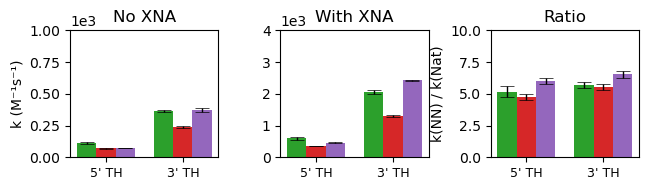


=== (Within-system) Wald tests: incubation comparisons within each system ===

System 5':
No vs Trigger: diff=-0.412 ± 0.513, Z=-0.804, p=4.211e-01, p_holm=4.211e-01
No vs Reporter: diff= 0.860 ± 0.499, Z= 1.724, p=8.478e-02, p_holm=1.696e-01

System 3':
No vs Trigger: diff=-0.128 ± 0.333, Z=-0.385, p=7.005e-01, p_holm=7.005e-01
No vs Reporter: diff= 0.882 ± 0.366, Z= 2.407, p=1.609e-02, p_holm=3.218e-02

=== (Between-system) Wald tests: 5' vs 3' for each incubation ===
No incubation    : diff=-0.508 ± 0.507, Z=-1.002, p=3.166e-01, p_holm=3.166e-01
Trigger incubated: diff=-0.792 ± 0.341, Z=-2.321, p=2.031e-02, p_holm=6.094e-02
Reporter incubated: diff=-0.530 ± 0.355, Z=-1.492, p=1.358e-01, p_holm=2.716e-01

=== Control ratios ===
TUM: 2.935 ± 0.330
UW:  5.407 ± 0.531
Z=-3.953, p=7.705e-05


In [72]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.stats import norm

fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(2)

labels = ["5' TH", "3' TH"]
x = np.arange(len(labels))
bar_width = 0.25

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 +
                   ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# ---------------------------------------------------------
# Data assembly for the three panels
# ---------------------------------------------------------

# Panel 0: No incubation
no_nat_data_together = [k_no_nat[3],      UW_k_no_nat[0]]
no_nn_data_together  = [k_no_nn[3],       UW_k_no_nn[0]]
no_R_data_together   = [
    [k_no_nn[3][0]      / k_no_nat[3][0],      prop_err(k_no_nn[3],      k_no_nat[3])],
    [UW_k_no_nn[0][0]   / UW_k_no_nat[0][0],   prop_err(UW_k_no_nn[0],   UW_k_no_nat[0])]
]

# Panel 1: Trigger incubated
trig_nat_data_together = [k_trig_nat[3],   UW_k_trig_nat[0]]
trig_nn_data_together  = [k_trig_nn[3],    UW_k_trig_nn[0]]
trig_R_data_together   = [
    [k_trig_nn[3][0]    / k_trig_nat[3][0],    prop_err(k_trig_nn[3],    k_trig_nat[3])],
    [UW_k_trig_nn[0][0] / UW_k_trig_nat[0][0], prop_err(UW_k_trig_nn[0], UW_k_trig_nat[0])]
]

# Panel 2: Reporter incubated
rep_nat_data_together = [k_rep_nat[3],     UW_k_rep_nat[0]]
rep_nn_data_together  = [k_rep_nn[3],      UW_k_rep_nn[0]]
rep_R_data_together   = [
    [k_rep_nn[3][0]     / k_rep_nat[3][0],     prop_err(k_rep_nn[3],     k_rep_nat[3])],
    [UW_k_rep_nn[0][0]  / UW_k_rep_nat[0][0],  prop_err(UW_k_rep_nn[0],  UW_k_rep_nat[0])]
]

# Grouped data for each condition and panel
datasets_panel0 = [
    (no_nat_data_together,   color_scheme[2], -bar_width),
    (trig_nat_data_together, color_scheme[3],  0),
    (rep_nat_data_together,  color_scheme[4],  bar_width),
]
datasets_panel1 = [
    (no_nn_data_together,    color_scheme[2], -bar_width),
    (trig_nn_data_together,  color_scheme[3],  0),
    (rep_nn_data_together,   color_scheme[4],  bar_width),
]
datasets_panel2 = [
    (no_R_data_together,     color_scheme[2], -bar_width),
    (trig_R_data_together,   color_scheme[3],  0),
    (rep_R_data_together,    color_scheme[4],  bar_width),
]

error_params = dict(ecolor='black', lw=1, capsize=5, capthick=0.5)

# ---------------------------------------------------------
# Plot panels
# ---------------------------------------------------------

# Panel 0: nat
for data_list, color, dx in datasets_panel0:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[0].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Panel 1: nn
for data_list, color, dx in datasets_panel1:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[1].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Panel 2: ratios
for data_list, color, dx in datasets_panel2:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    print("ratio y, e:", y, e)
    ax[2].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=9)
    a.set_ylim(0, 10)
    a.tick_params(axis='x')

ax[0].set_ylabel('k (M⁻¹s⁻¹)', fontsize=10)
ax[2].set_ylabel('k(NN) / k(Nat)', fontsize=10)

ax[0].set_ylim(0, 1000)
ax[1].set_ylim(0, 4000)

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)

ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 

plt.tight_layout()
plt.savefig('NAR_onestep_compare_k.svg', dpi=400)
plt.show()

# ============================================================
# ===  STATISTICS: Wald tests + Holm corrections ============
# ===  (no comparisons to control) ==========================
# ============================================================

def wald_z(diff, se_diff):
    Z = diff / se_diff
    p = 2 * (1 - norm.cdf(abs(Z)))
    return Z, p

def holm_correction(pvals):
    """Holm step-down adjustment; returns adjusted p-values in original order."""
    m = len(pvals)
    order = sorted(range(m), key=lambda i: pvals[i])  # indices sorted by p
    adjusted = [0.0] * m
    prev = 0.0
    for rank, i in enumerate(order):
        k = m - rank
        adj = min(1.0, pvals[i] * k)
        adj = max(adj, prev)  # enforce monotonicity
        adjusted[i] = adj
        prev = adj
    return adjusted

# Each block: [ [ratio_5p, se_5p], [ratio_3p, se_3p] ]
ratio_blocks = [no_R_data_together, trig_R_data_together, rep_R_data_together]
incubations = ['No incubation', 'Trigger incubated', 'Reporter incubated']

# Convenience: ratios per system
ratios_5 = [block[0] for block in ratio_blocks]  # 5′ system
ratios_3 = [block[1] for block in ratio_blocks]  # 3′ system

# ---------------------------------------------------------
# (2) Within each system: No vs Trigger, No vs Reporter
# ---------------------------------------------------------
print("\n=== (Within-system) Wald tests: incubation comparisons within each system ===")

for sys_label, ratio_list in zip(["5'", "3'"], [ratios_5, ratios_3]):
    print(f"\nSystem {sys_label}:")
    comparisons = [
        (0, 1, 'No vs Trigger'),
        (0, 2, 'No vs Reporter'),
    ]
    pvals = []
    rows  = []
    for i1, i2, label in comparisons:
        r1, se1 = ratio_list[i1]
        r2, se2 = ratio_list[i2]
        diff = r2 - r1
        se_diff = sqrt(se1**2 + se2**2)
        Z, p = wald_z(diff, se_diff)
        pvals.append(p)
        rows.append((label, diff, se_diff, Z, p))
    p_adj = holm_correction(pvals)
    for (label, diff, se_diff, Z, p_raw), p_corr in zip(rows, p_adj):
        print(f"{label:13s}: diff={diff:6.3f} ± {se_diff:5.3f}, "
              f"Z={Z:6.3f}, p={p_raw:8.3e}, p_holm={p_corr:8.3e}")

# ---------------------------------------------------------
# (3) Between systems: 5' vs 3' for each incubation
# ---------------------------------------------------------
print("\n=== (Between-system) Wald tests: 5' vs 3' for each incubation ===")

pvals_sys = []
results_sys = []
for cond, (r5, se5), (r3, se3) in zip(incubations, ratios_5, ratios_3):
    diff = r5 - r3
    se_diff = sqrt(se5**2 + se3**2)
    Z, p = wald_z(diff, se_diff)
    pvals_sys.append(p)
    results_sys.append((cond, diff, se_diff, Z, p))

p_adj_sys = holm_correction(pvals_sys)

for (cond, diff, se_diff, Z, p_raw), p_corr in zip(results_sys, p_adj_sys):
    print(f"{cond:17s}: diff={diff:6.3f} ± {se_diff:5.3f}, "
          f"Z={Z:6.3f}, p={p_raw:8.3e}, p_holm={p_corr:8.3e}")


# Print rate constant ratios for the controls for both 5' and 3'
print("\n=== Control ratios ===")
# Control ratio line + band
TUM_control_ratio = k_control_nn[0][0] / k_control_nat[0][0]
TUM_control_ratio_se = prop_err(k_control_nn[0], k_control_nat[0])
UW_control_ratio = UW_k_control_nn[0][0] / UW_k_control_nat[0][0]
UW_control_ratio_se = prop_err(UW_k_control_nn[0], UW_k_control_nat[0])
print(f"TUM: {TUM_control_ratio:.3f} ± {TUM_control_ratio_se:.3f}")
print(f"UW:  {UW_control_ratio:.3f} ± {UW_control_ratio_se:.3f}")
#wald z test for the control ratios
Z, p = wald_z(TUM_control_ratio - UW_control_ratio, sqrt(TUM_control_ratio_se**2 + UW_control_ratio_se**2))
print(f"Z={Z:.3f}, p={p:.3e}")  


In [73]:
R = 0.001987 
T_UW = 25 + 273
T_TUM = 29 + 273
RT_UW = R*T_UW
RT_TUM = R*T_TUM
m_UW = -np.log10(np.e)/(RT_UW)
m_TUM = -np.log10(np.e)/(RT_TUM)
m_UW, m_TUM

(-0.7334494379629535, -0.7237348758707289)

In [74]:
#expected free energy change
np.log10(5.407)/m_UW

-0.9993277404524321

In [75]:
#expected free energy change
np.log10(2.935)/m_TUM

-0.6461041483195786

## Overview

In [27]:

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 + ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# Input labels and data
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['No incubation']
colors = [color_scheme[2]]
bar_width = 0.2



# Prepare experimental data
no = [kb_no_nat, kb_no_nn]
systems = [no]

# fold[i][j]: condition i, group j
n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Set up x-axis positions
x_control = 0
x_group_start = 1  # reserve space for control
x_group = np.arange(n_groups) + x_group_start  # center position for each group
x_offsets = np.linspace(-bar_width, bar_width, n_conditions)  # offset for each bar in a group

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)



# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], label=conditions[i], error_kw=error_params)

# Format x-axis
x_ticks = list(x_group)
x_labels =  group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

ax.set_ylabel('Rate constant ratio (NN / Nat)', fontsize=10)
ax.set_ylim(0, 5)
ax.set_title('Rate Constant Ratios Across Conditions', fontsize=11)





plt.tight_layout()
#plt.savefig("Onestep_InitK_grouped_barplot_err.svg", dpi=400)
plt.show()


NameError: name 'kb_no_nat' is not defined

In [ ]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

In [ ]:
number_of_points = 15

## Fitting

### Controls

#### Natural

Fitted kf = 4.6e+00 ± 9.1e-02


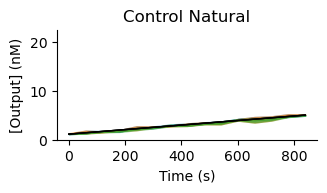

In [ ]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]





to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

initial_k = 2e1



res = []
slopes = []
intercepts = []
for curve in to_fit[0]:
  res += [linregress(x_trunc, curve)]
  slopes += [res[-1].slope]
  intercepts += [res[-1].intercept]


fitted_kf = np.mean(slopes)
param_sd_kf = np.std(slopes)
intercept = np.mean(intercepts)

def model(x, intercept, slope):
  return np.array(x)*slope + intercept

k_control_nat = [fitted_kf, param_sd_kf]

control_nat_model = [intercept, fitted_kf]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 1

for i,curve in enumerate(to_fit[0]):
  ax.plot(x, model(x, intercept, fitted_kf), color='black',linewidth=line)
  ax.scatter(x_trunc,[1e9*i for i in curve], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[0][i])),np.array(curve), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc, curve, (np.array(curve)+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)


print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (s)')
ax.set_title("Control Natural")
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_r.svg', dpi = 400)
plt.show()


Fitted kf = 1.0e+01 ± 4.4e-02


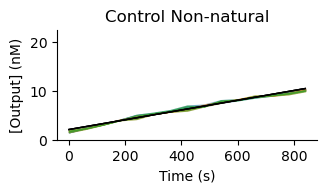

In [ ]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]




to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]



initial_k = 2e1


res = []
slopes = []
intercepts = []
for curve in to_fit[0]:
  res += [linregress(x_trunc, curve)]
  slopes += [res[-1].slope]
  intercepts += [res[-1].intercept]


fitted_kf = np.mean(slopes)
param_sd_kf = np.std(slopes)

intercept = np.mean(intercepts)



def model(x, intercept, slope):
  return np.array(x)*slope + intercept

k_control_nn = [fitted_kf, param_sd_kf]

control_nn_model = [intercept, fitted_kf]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 1

for i,curve in enumerate(to_fit[0]):
  ax.plot(x, model(x, intercept, fitted_kf), color='black',linewidth=line)
  ax.scatter(x_trunc,[1e9*i for i in curve], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[0][i])),np.array(curve), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc, curve, (np.array(curve)+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)


print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (s)')
ax.set_title("Control Non-natural")
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nnt_r.svg', dpi = 400)
plt.show()


#### NN

### No incubation
         

#### Nat

Fitted kf = 1.9e+00 ± 1.1e-01
Fitted kf = 8.1e-01 ± 8.4e-02
Fitted kf = 3.2e-01 ± 1.4e-01
Fitted kf = 1.9e-01 ± 4.2e-02


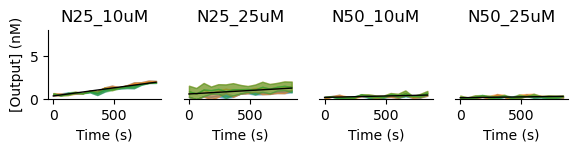

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']

data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_no[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [0, 2, 4, 6]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]




def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_no_nat = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_no_nat.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc_r.svg', dpi = 500, transparent=True)
plt.show()


#### NN

Fitted kf = 5.6e+00 ± 2.2e-01
Fitted kf = 3.3e+00 ± 3.6e-01
Fitted kf = 2.0e+00 ± 8.3e-02
Fitted kf = 7.6e-01 ± 1.2e-02


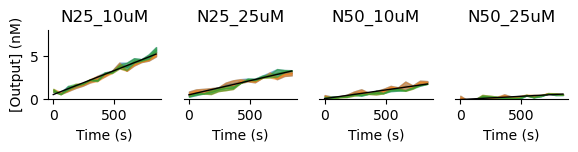

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_no[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [1, 3, 5, 7]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_no_nn = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_no_nn.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_noinc_r.svg', dpi = 500, transparent=True)
plt.show()


### Trig
         

#### Nat

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_trig[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [0, 1, 2, 3]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]

def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_trig_nat = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_trig_nat.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_trig_r.svg', dpi = 500, transparent=True)
plt.show()


NameError: name 'intercepts' is not defined

#### NN

Fitted kf = 4.1e+00 ± 1.2e-01
Fitted kf = 1.8e+00 ± 9.8e-02
Fitted kf = 6.2e-01 ± 1.2e-01
Fitted kf = 3.2e-02 ± 1.1e-01


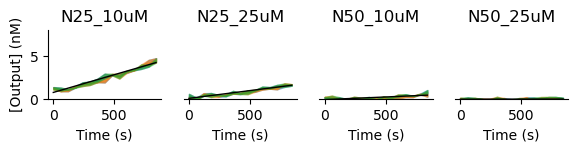

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_trig[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [4, 5, 6, 7]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_trig_nn = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")



  k_trig_nn.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_trig_r.svg', dpi = 500, transparent=True)
plt.show()


### Rep
         

#### Nat

Fitted kf = 1.2e+00 ± 8.7e-03
Fitted kf = 4.1e-01 ± 9.2e-02
Fitted kf = 3.2e-01 ± 3.2e-02
Fitted kf = 1.8e-01 ± 1.0e-01


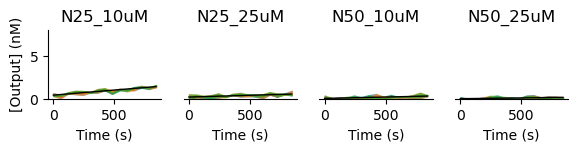

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_rep[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [0, 1, 2, 3]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_rep_nat = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_rep_nat.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_rep_r.svg', dpi = 500, transparent=True)
plt.show()


#### NN

Fitted kf = 4.1e+00 ± 1.2e-01
Fitted kf = 1.8e+00 ± 9.8e-02
Fitted kf = 6.2e-01 ± 1.2e-01
Fitted kf = 3.2e-02 ± 1.1e-01


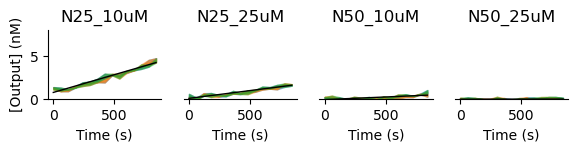

In [ ]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_rep[0:number_of_points]
conditions = conditions_TUM_rep
levels = list(conditions.keys())
offset = offset_TUM_rep
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_rep[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for i,l in enumerate(levels):
  if i in [4, 5, 6, 7]:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]
x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept



intercept = np.mean(intercepts)
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 1

k_rep_nn = []
for i,a in enumerate(ax):
  res = []
  slopes = []
  intercepts = []
  for j,curve in enumerate(to_fit[i]):
    res += [linregress(x_trunc, curve)]
    slopes += [res[-1].slope]
    intercepts += [res[-1].intercept]
    a.scatter(x_trunc,[1e9*c for c in curve], color=color_scheme[j], s = 10)
    a.fill_between(x_trunc,(np.array(curve)-np.array(stdDev[i][j])),np.array(curve), color=color_scheme[j], alpha= alph)
    a.fill_between(x_trunc,curve,  (np.array(curve)+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

  fitted_kf = np.mean(slopes)
  param_sd_kf = np.std(slopes)
  intercept = np.mean(intercepts)
  print(f"Fitted kf = {1000*fitted_kf:.1e} ± {1000*param_sd_kf:.1e}")

  k_rep_nn.append([fitted_kf, param_sd_kf])
  a.plot(x, model(x, intercept, fitted_kf), 'black',linewidth=line)




  a.set_xlabel('Time (s)')
  a.set_title(f"{labels[i]}")
  a.spines['left'].set_visible(False)
  a.spines['right'].set_visible(False)
  a.spines['top'].set_visible(False)
  a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)

ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,8)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nn_rep_r.svg', dpi = 500, transparent=True)
plt.show()


## Summary Data

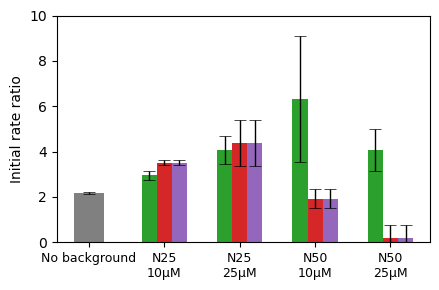

In [ ]:
# Define propagated error from slope + stderr
def prop_err(res_num, res_denom):
    return np.sqrt(((1 / res_denom[0]) * res_num[1]) ** 2 +
                   ((res_num[0] / (res_denom[0] ** 2)) * res_denom[1]) ** 2)

# Labels
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['No incubation', 'Trigger incubated', 'Reporter incubated']
colors = [color_scheme[2], color_scheme[3], color_scheme[4]]
bar_width = 0.2

# Control baseline
controls = [k_control_nat, k_control_nn]
base = controls[1][0] / controls[0][0]
e_base = prop_err(controls[1], controls[0])

# Collect fold changes and errors
no = [k_no_nat, k_no_nn]
trig = [k_trig_nat, k_trig_nn]
rep = [k_rep_nat, k_rep_nn]
systems = [no, trig, rep]

n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Bar positions
x_control = 0
x_group_start = 1
x_group = np.arange(n_groups) + x_group_start
x_offsets = np.linspace(-bar_width, bar_width, n_conditions)

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)

# Control bar
ax.bar(x_control, base, bar_width*2, yerr=e_base, color='gray', label='No background', error_kw=error_params)

# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], capsize=4, label=conditions[i], error_kw=error_params)

# X-axis

x_ticks = [x_control] + list(x_group)
x_labels = ['No background'] + group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

# Y-axis and labels
ax.set_ylabel('Initial rate ratio', fontsize=10)
ax.set_ylim(0, 10)

# Legend

plt.tight_layout()
#plt.savefig("Onestep_InitR_grouped_barplot_err.svg", dpi=400)
plt.show()


# Example figures

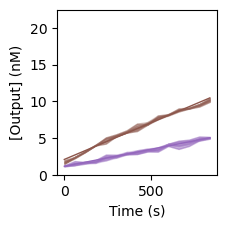

In [ ]:
number_of_points = 15

data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]



data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [np.array(c[1]) for c in curves]

x_trunc = curves[0][0]


def model(x, intercept, slope):
  return np.array(x)*slope + intercept

k_control_nat = [res]

fig, ax = plt.subplots(1,1, figsize = (2,3))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.3
size = 5
line = 1

models = [control_nat_model, control_nn_model]
for i,curves in enumerate(to_fit):
  for j,c in enumerate(curves):
    ax.scatter(x_trunc,[1e9*i for i in c], color=color_scheme[4+(i%2)], s = 10)
    ax.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[4+(i%2)], alpha= alph)
    ax.fill_between(x_trunc,c,  (np.array(c)+np.array(stdDev[i][j])), color=color_scheme[4+(i%2)], alpha= alph)
  ax.plot(x, model(x, models[i][0], models[i][1]), color=color_scheme[4 + (i%2)],linewidth=line)

ax.set_ylim(0,22.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('[Output] (nM)')



#plt.savefig('ExampleLinear.svg', dpi = 400, transparent=True)
plt.show()


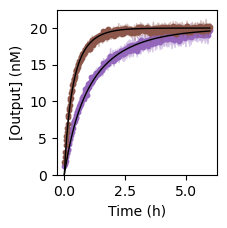

In [ ]:
number_of_points = 6*3600//60

data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getAverageCurve(start, offset, l, x, data, conditions, fit)[0],getAverageCurve(start, offset, l, x, data, conditions, fit)[1]]]
    stdDev += [getAverageCurve(start, offset, l, x, data, conditions, fit)[2]]


data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = t_TUM_controls[0:number_of_points]

for l in levels:
    curves += [[getAverageCurve(start, offset, l, x, data, conditions, fit)[0],getAverageCurve(start, offset, l, x, data, conditions, fit)[1]]]
    stdDev += [getAverageCurve(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [np.array(c[1])*1e-9 for c in curves]

x_trunc = curves[0][0]



def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, tfull, fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
]


k_control_nat = [res]

fig, ax = plt.subplots(1,1, figsize = (2,3))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.3
size = 5
line = 1

fitted = [7.505e+03, 2.218e+04]

xv = [t/3600 for t in x]
x_trunc = [t/3600 for t in x_trunc]

models = [control_nat_model, control_nn_model]
for i,c in enumerate(to_fit):
  ax.plot(xv,[i*1e9 for i in modelOneStep(fitted[i], x, fixed_params_list[i])], color='black',linewidth=line)
  ax.scatter(x_trunc,[1e9*i for i in c], color=color_scheme[4+(i%2)], s = 10)
  ax.fill_between(x_trunc,(np.array(curves[i][1])-np.array(stdDev[i])),curves[i][1], color=color_scheme[4+(i%2)], alpha= alph)
  ax.fill_between(x_trunc,curves[i][1],  (np.array(curves[i][1])+np.array(stdDev[i])), color=color_scheme[4+(i%2)], alpha= alph)

ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_ylabel('[Output] (nM)')


#plt.savefig('ExampleK_var.svg', dpi = 400, transparent=True)
plt.show()
